#### Khai báo thư viện cần thiết

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Đọc dữ liệu

In [2]:
# Đọc file dữ liệu
cleaned_df = pd.read_csv('./data/cleaned_air_quality_health_impact_data.csv')

# Đọc file kiểu dữ liệu mỗi cột
data_types = pd.read_csv('./data/data-types.csv')
data_types.set_index(data_types.columns[0], inplace = True)
data_types.index.name = None
# Chuyển đổi kiểu dữ liệu
for name in data_types.index:
    cleaned_df[name] = cleaned_df[name].astype(data_types.loc[name, 'Data Type'])

# Đọc ma trận tương quan
correlation_matrix = pd.read_csv('./data/correlation_matrix.csv')
correlation_matrix.set_index(correlation_matrix.columns[0], inplace = True)
correlation_matrix.index.name = None

#### Phân tích tổng quan

Trước khi đặt và phân tích những câu hỏi về sự ảnh hưởng lẫn nhau của các thuộc tính, ta thực hiện phân tích tổng quan về dữ liệu.
1. Chất lượng không khí
    * Phân phối chỉ số AQI, PM10, PM2.5, NO2, SO2, O3 như thế nào trong bộ dữ liệu?
2. Tác động đến sức khỏe
   * Phân phối của RespiratoryCases, CardiovascularCases, và HospitalAdmissions ra sao? Những trường hợp nào phổ biến nhất?
   * Phân phối các lớp tác động sức khỏe (HealthImpactClass) như thế nào? Lớp nào chiếm ưu thế?
3. Thời tiết và ô nhiễm
   * Điều kiện thời tiết (nhiệt độ, độ ẩm, tốc độ gió) phân phối như thế nào?

##### Sử dụng histogram để xem các chỉ số ô nhiễm tập trung ở những giá trị nào

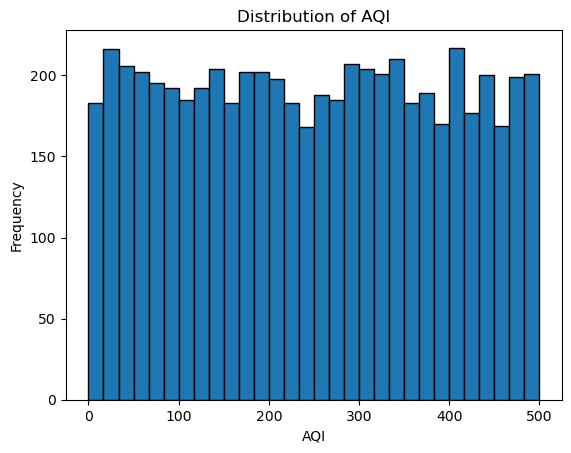

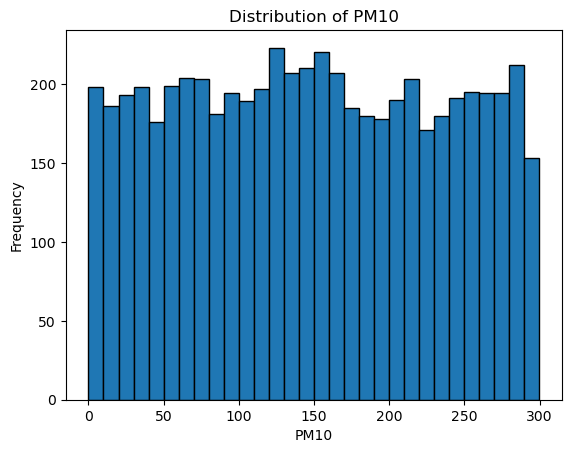

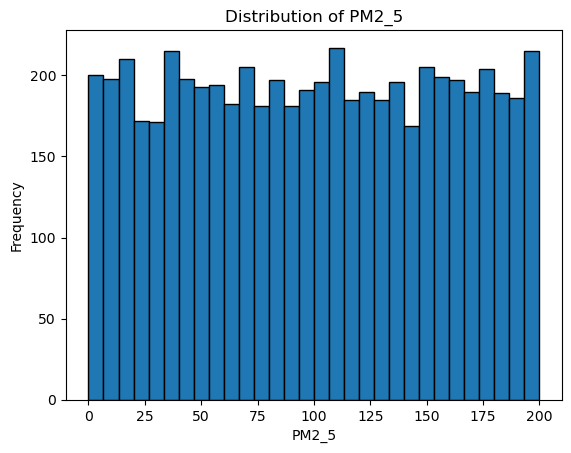

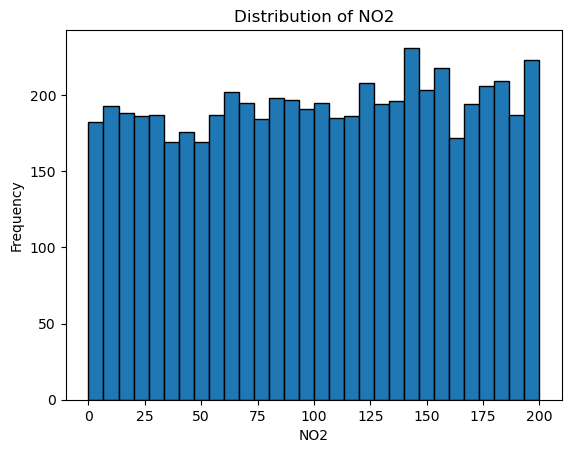

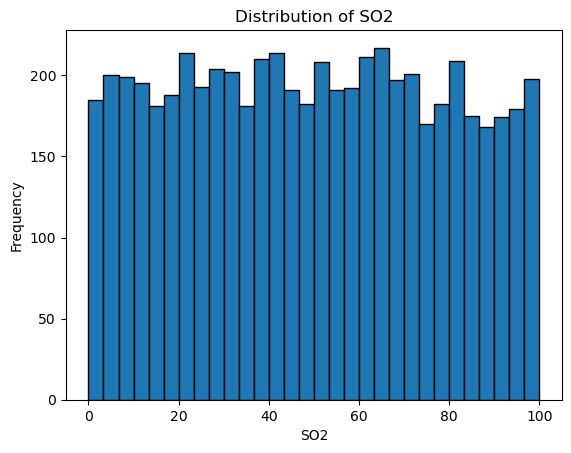

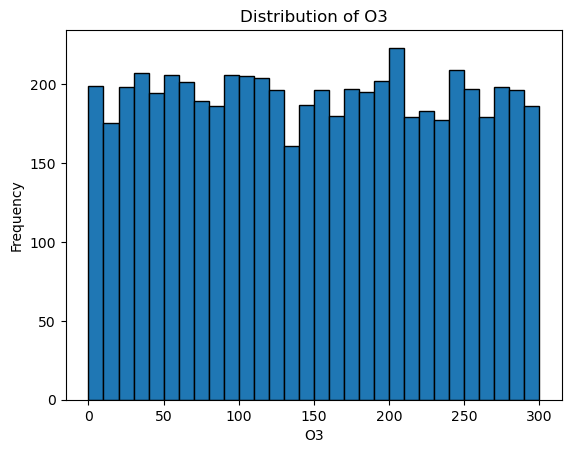

In [3]:
air_quality_metrics = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']

for metric in air_quality_metrics:
    plt.hist(cleaned_df[metric], bins = 30, edgecolor = 'black')
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

Các dữ liệu phân phố đều nhau, không có nhóm nào chiếm ưu thế hơn nhóm khác và không có bin nào độc lập so với bin khác.

##### Sử dụng bar chart để xem nhóm sức khỏe nào phổ biến nhất (vì đây là các giá trị rời rạc)

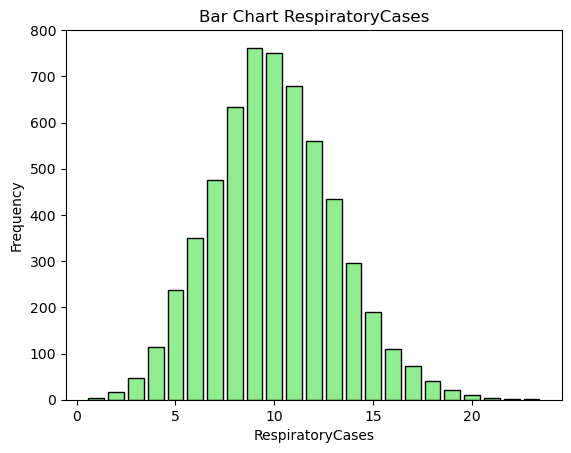

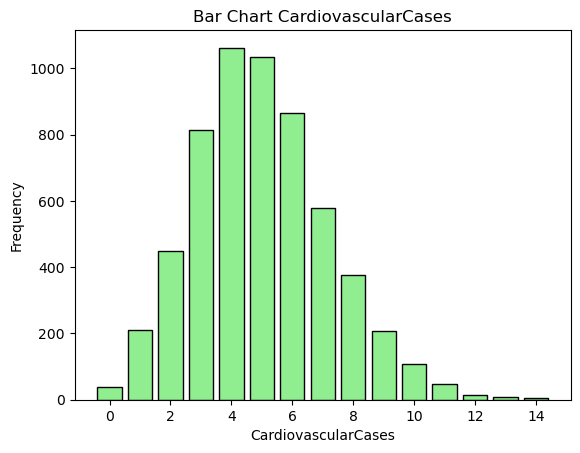

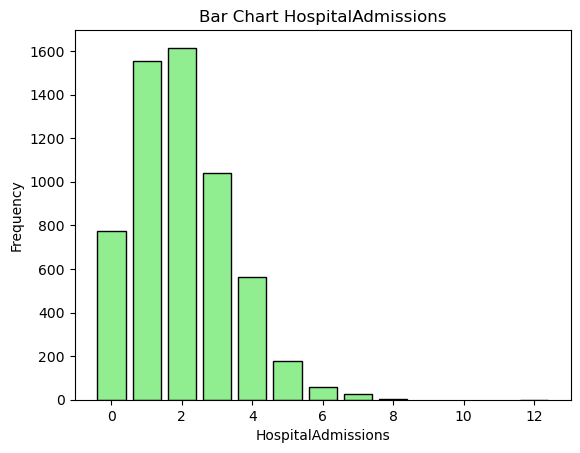

In [4]:
health_metrics = ['RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions']

for metric in health_metrics:
    counts = cleaned_df[metric].value_counts()
    plt.bar(counts.index, counts.values, color = 'lightgreen', edgecolor = 'black')
    plt.title(f'Bar Chart {metric}')
    plt.xlabel(f'{metric}')
    plt.ylabel('Frequency')
    plt.show()


Nhận xét:
* Mặc dù đây là những biểu đồ có kiểu dữ liệu rời rạc (và có thứ tự) nhưng nó có hình dạng gần với phân phối chuẩn: có hình chuông, đối xứng và giảm dần về hai phía
* Số ca bệnh liên quan đến đường hô hấp tập trung cao nhất là 9-10 ca.
* Số ca bệnh tim mạch tập trung cao nhất là 4-5 ca.
* Số ca nhập viện tập trung cao nhất là 1-2 ca.

##### Sử dụng bar chart để xem nhóm tác động đến sức khỏe nào phổ biến nhất (vì đây là các giá trị rời rạc)

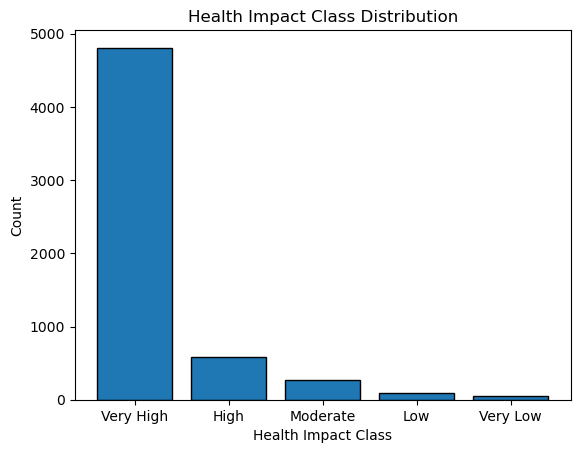

In [5]:
impact_class_counts = cleaned_df['HealthImpactClass'].value_counts()

plt.bar(impact_class_counts.index, impact_class_counts.values, edgecolor = 'black')
plt.title("Health Impact Class Distribution")
plt.xlabel("Health Impact Class")
plt.ylabel("Count")
plt.xticks([0, 1, 2, 3, 4], ["Very High", "High", "Moderate", "Low", "Very Low"])
plt.show()

Nhận xét:
* Có rất nhiều nơi mà sự tác động của không khí đến sức khỏe của người dân là rất cao. 

##### Sử dụng histogram để xem sự phân bố của thời tiết như thế nào?

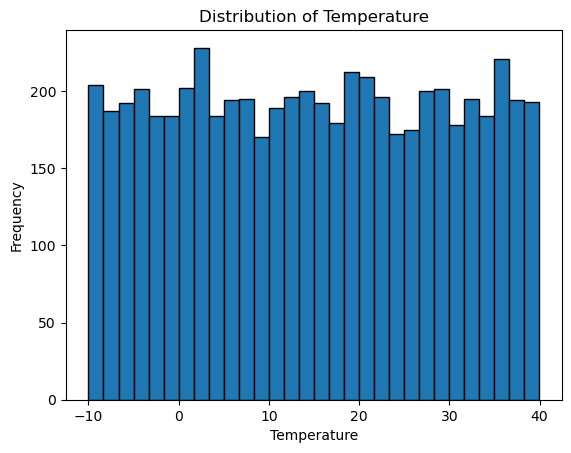

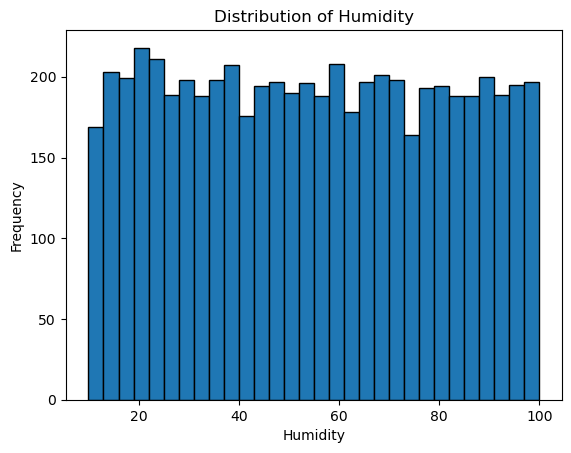

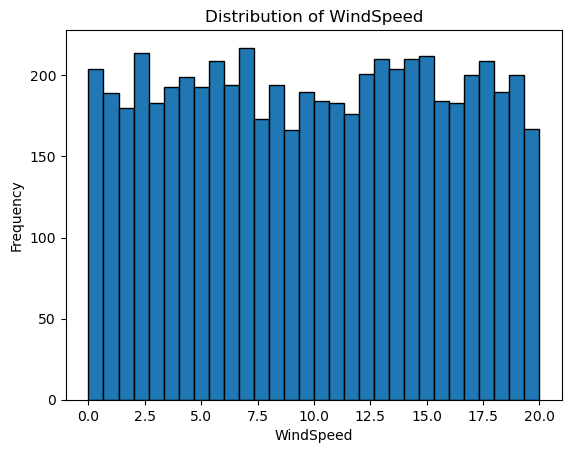

In [6]:
weather_metrics = ['Temperature', 'Humidity', 'WindSpeed']

for metric in weather_metrics:
    plt.hist(cleaned_df[metric], bins = 30, edgecolor = 'black')
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

Các dữ liệu phân phố khá đều nhau, không có nhóm nào chiếm ưu thế hơn nhóm khác và không có bin nào độc lập với bin khác.

#### Phân tích mối quan hệ

#### Câu 1: Chỉ số ô nhiễm nào có tác động lớn nhất đến sức khỏe?
để trả lời cho câu hỏi trên thì các yếu tố AQI, PM10, PM2_5, NO2, O3 tương quan với HeathImpactScore như thế nào?

Trích ma trận tương quan giữa các chỉ số ô nhiễm và HealthImpactScore

In [7]:
pollutants = ['AQI', 'PM10', 'PM2_5', 'NO2', 'O3']
health_corr = correlation_matrix.loc[pollutants, 'HealthImpactScore']
print(health_corr)

AQI      0.614560
PM10     0.182600
PM2_5    0.220347
NO2      0.124435
O3       0.157940
Name: HealthImpactScore, dtype: float64


**Phân tích hệ số tương quan**:
- AQI (0.615):
Tương quan khá mạnh và dương, cho thấy AQI tăng sẽ làm tăng đáng kể HealthImpactScore.
Do AQI là một chỉ số tổng hợp của nhiều chất ô nhiễm, kết quả này phù hợp với kỳ vọng rằng khi mức độ ô nhiễm tổng thể tăng, tác động tiêu cực đến sức khỏe cũng tăng mạnh.

- PM2_5 (0.220):
Tương quan dương ở mức yếu, cho thấy nồng độ PM2.5 cao có tác động tiêu cực đến sức khỏe, nhưng không mạnh bằng AQI.
Điều này có thể là do PM2.5 là thành phần quan trọng trong AQI, nhưng ảnh hưởng của nó cũng bị phân tán bởi các yếu tố khác như điều kiện khí hậu và thời gian tiếp xúc.

- PM10 (0.183):
Tương quan dương yếu, cho thấy bụi PM10 có tác động nhưng không đáng kể.
PM10 ít nguy hiểm hơn PM2_5 vì kích thước lớn hơn, thường chỉ gây kích ứng đường hô hấp trên.

- NO₂ (0.124):
Tương quan dương rất yếu, phản ánh rằng NO₂ không phải là yếu tố chính gây ảnh hưởng đến sức khỏe trong tập dữ liệu này.
Có thể NO₂ tác động gián tiếp thông qua việc hình thành ozone mặt đất (O₃).

- O₃ (0.158):
Tương quan dương yếu, cho thấy ozone mặt đất có tác động tiêu cực nhẹ đến sức khỏe.
Điều này có thể do O₃ gây kích ứng đường hô hấp, nhưng ảnh hưởng của nó bị hạn chế bởi sự biến đổi theo thời gian trong ngày và các điều kiện môi trường khác.

  *Từ đó ta thấy rằng các hệ số tương quan giữa các chỉ số ô nhiễm (AQI, PM2.5, PM10, NO₂, O₃) và HealthImpactScore đều không đạt mức hoàn toàn mạnh vì vậy HealthImpactScore không chỉ phụ thuộc vào các yếu tố ô nhiễm, mà còn chịu ảnh hưởng bởi điều kiện khí hậu và một số yếu tố đời thật như đặc điểm nhân khẩu học (tuổi, bệnh nền), thời gian phơi nhiễm.*

**Để xem những nhận xét tương quan trên có hợp lý không ta biểu diễn sự phân tán của các chỉ số theo nhóm HealthImpactScore**

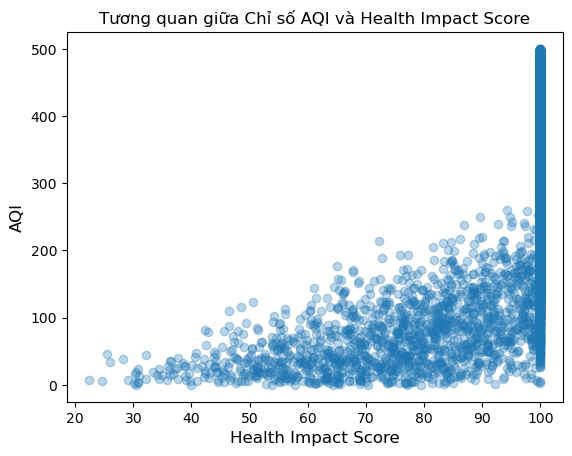

In [8]:
plt.scatter(cleaned_df['HealthImpactScore'], cleaned_df['AQI'], alpha = 0.3);
plt.title('Tương quan giữa Chỉ số AQI và Health Impact Score')
plt.xlabel('Health Impact Score', fontsize = 12)
plt.ylabel('AQI', fontsize = 12);

- AQI (Chỉ số chất lượng không khí): Xu hướng tăng rõ rệt theo mức độ tác động sức khỏe từ thấp (ít tác động) đến cao (tác động nghiêm trọng).
- Nhưng ở mức tác động nghiêm trọng (Health Impact Score = 100) thì AQI phân bố rất rộng và có những điểm lớn hơn những điểm còn lại rất nhiều. Chứng tỏ, nhóm mức độ nghiêm trọng này có thể có thêm những nhóm dữ liệu khác (nghiêm trọng, cực kì nghiêm trọng, ...) nhưng vì có thể đây đã là mức rất nghiêm trọng rồi nên không cần chia.

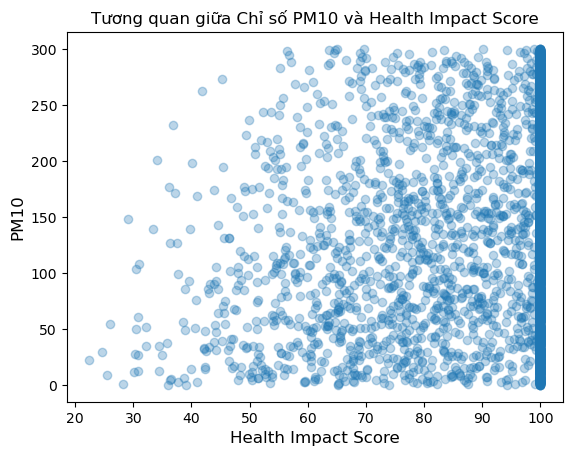

In [9]:
plt.scatter(cleaned_df['HealthImpactScore'], cleaned_df['PM10'], alpha = 0.3);
plt.title('Tương quan giữa Chỉ số PM10 và Health Impact Score')
plt.xlabel('Health Impact Score', fontsize = 12)
plt.ylabel('PM10', fontsize = 12);

- PM10 không ảnh hưởng vào Health Impact Score một cách rõ ràng nhưng nhìn chung thì ở mức độ ảnh hưởng thấp (20-40) thì PM10 thấp hơn các mức độ ảnh hưởng cao hơn.

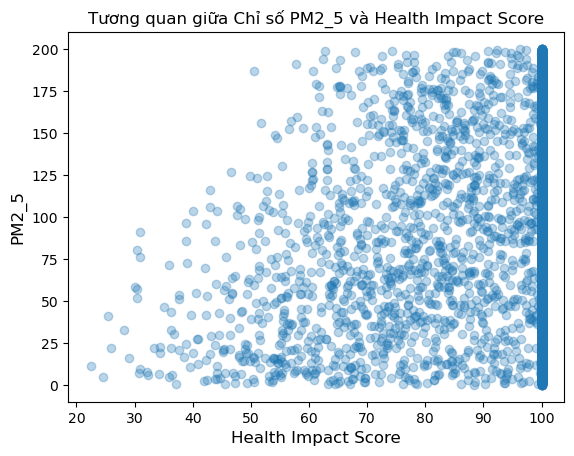

In [10]:
plt.scatter(cleaned_df['HealthImpactScore'], cleaned_df['PM2_5'], alpha = 0.3);
plt.title('Tương quan giữa Chỉ số PM2_5 và Health Impact Score')
plt.xlabel('Health Impact Score', fontsize = 12)
plt.ylabel('PM2_5', fontsize = 12);

- PM2_5 không quá ảnh hưởng vào Health Impact Score nhưng phân tán rõ ràng hơn PM10 ở mức ảnh hưởng thấp. Có xu hướng tăng từ mức ảnh hưởng 20 - 30.

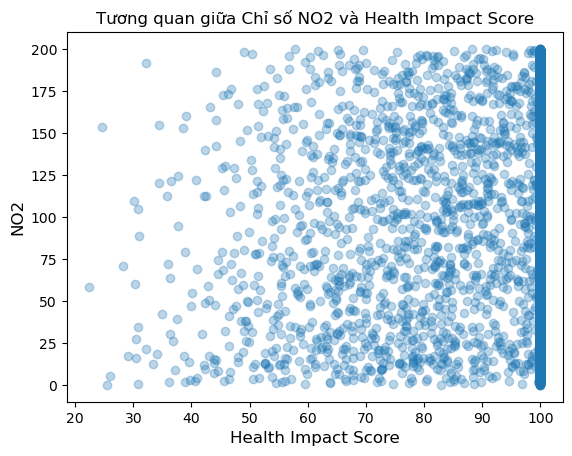

In [11]:
plt.scatter(cleaned_df['HealthImpactScore'], cleaned_df['NO2'], alpha = 0.3);
plt.title('Tương quan giữa Chỉ số NO2 và Health Impact Score')
plt.xlabel('Health Impact Score', fontsize = 12)
plt.ylabel('NO2', fontsize = 12);

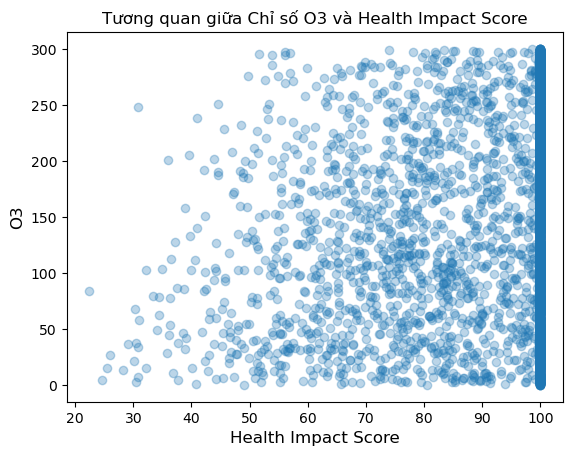

In [12]:
plt.scatter(cleaned_df['HealthImpactScore'], cleaned_df['O3'], alpha = 0.3);
plt.title('Tương quan giữa Chỉ số O3 và Health Impact Score')
plt.xlabel('Health Impact Score', fontsize = 12)
plt.ylabel('O3', fontsize = 12);

Cả NO2 và O3 đều ảnh hưởng đến Health Impact Score không quá rõ ràng.

**Nhận xét chung**:
- Đánh giá mức độ tương quan tương đồng với đánh giá thông qua đồ thị phân tán.
- AQI là một đặc trưng được tổng hợp từ các chỉ số ô nhiễm và có ảnh hưởng đến Health Impact Score.
- Nhưng khi xét riêng lẻ các đặc trưng thì nó không gây ảnh hưởng đến đặc trưng Health Impact Score. Nghĩa là từng đặc trưng ô nhiễm sẽ ảnh hưởng đến từng đặc trưng sức khỏe riêng.

#### Câu 2: Những vùng có mức độ ảnh hưởng đến sức khỏe là 'Rất cao' thường sẽ có điều kiện thời tiết như thế nào?

##### Nhiệt độ

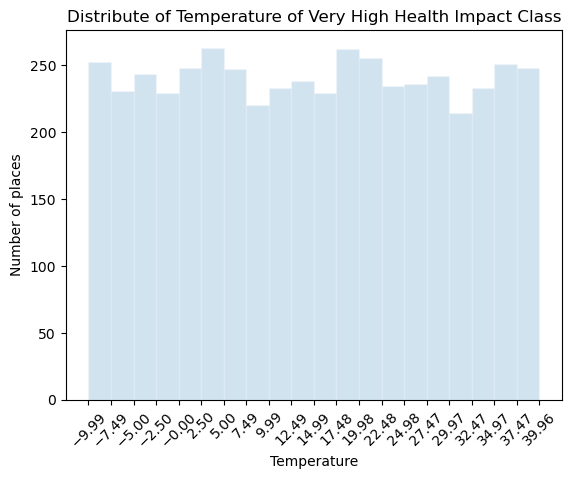

In [13]:
very_high_impact = cleaned_df[cleaned_df['HealthImpactClass'] == 0.0]

hist = plt.hist(very_high_impact['Temperature'], bins = 20, edgecolor = 'white', alpha = 0.2)
plt.title('Distribute of Temperature of Very High Health Impact Class')
plt.xlabel('Temperature')
plt.ylabel('Number of places')
plt.xticks(hist[1], rotation = 45);

- Nhiệt độ tại các vùng có mức ảnh hưởng đến sức khỏe 'Rất cao' có phân bố từ -10 độ C đến 40 độ C, và chúng phân bố khá đều. 
- Nhưng có thể thấy ở khoảng nhiệt độ từ 0-7.5 độ C và 17.5-22.5 độ C thì có số lượng nhiều hơn hẵn những nhóm khác. Có nghĩa là mức ảnh hưởng 'rất cao' xảy ra nhiều hơn đối với những nơi có nhiệt thuộc nhóm này

##### Độ ẩm

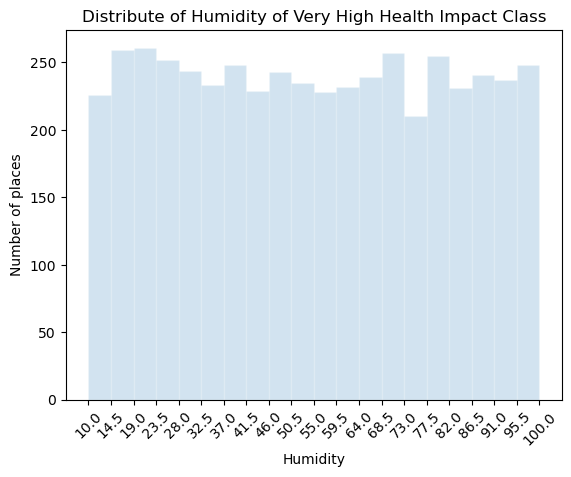

In [14]:
hist = plt.hist(very_high_impact['Humidity'], bins = 20, edgecolor = 'white', alpha = 0.2)
plt.title('Distribute of Humidity of Very High Health Impact Class')
plt.xlabel('Humidity')
plt.ylabel('Number of places')
plt.xticks(hist[1], rotation = 45);

- Độ ẩm tại các vùng có mức ảnh hưởng đến sức khỏe 'Rất cao' có phân bố từ 10% đến 100%, và chúng phân bố rất đều. Nhưng có thể thấy ở khoảng độ ẩm từ 14.5-23.5%, 68.5-73% và 77.5-82.0% thì có số lượng nhiều hơn hẵn những nhóm khác. Có nghĩa là mức ảnh hưởng 'rất cao' xảy ra nhiều hơn đối với những nơi có độ ẩm thuộc nhóm này.

##### Tốc độ gió

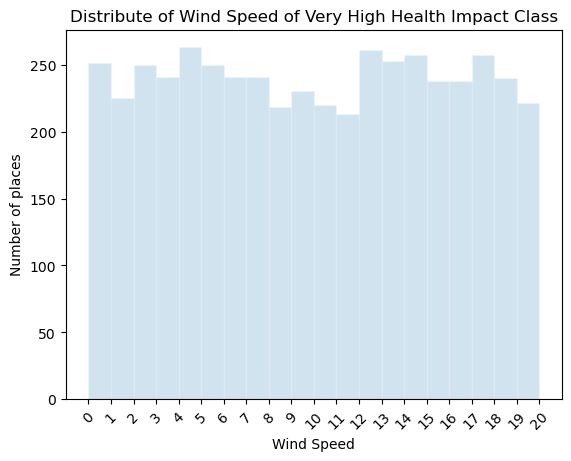

In [15]:
hist = plt.hist(very_high_impact['WindSpeed'], bins = 20, edgecolor = 'white', alpha = 0.2)
plt.title('Distribute of Wind Speed of Very High Health Impact Class')
plt.xlabel('Wind Speed')
plt.ylabel('Number of places')
plt.xticks(hist[1], rotation = 45);

- Tốc độ gió tại các vùng có mức ảnh hưởng đến sức khỏe 'Rất cao' có phân bố từ 0 đến 20 m/s, và chúng phân bố rất đều. Nhưng có thể thấy ở khoảng độ ẩm từ 4-5 m/s, 12-15 m/s và 17-18 m/s thì có số lượng nhiều hơn hẵn những nhóm khác. Có nghĩa là mức ảnh hưởng 'rất cao' xảy ra nhiều hơn đối với những nơi có tốc độ gió thuộc nhóm này.

#### Câu 3: Nồng độ bụi trong không khí có ảnh hưởng như thế nào đến số ca bệnh về đường hô hấp?

##### 1. Phân loại nồng độ bụi vào các nhóm cụ thể

**Cơ sở phân loại:** [Thang đo](https://boneco.vn/chi-so-bui-min-pm-25-pm10-bao-nhieu-la-an-toan-cho-suc-khoe-88322.html)

In [77]:
# Lấy các cột dữ liệu cần thiết
pm_info = cleaned_df[['RespiratoryCases', 'PM2_5', 'PM10']].copy()
# Hiển thị mẫu
pm_info.head(5)

,RespiratoryCases,PM2_5,PM10
0,7,13.038560,295.853039
1,10,9.984497,246.254703
2,13,23.111340,84.443191
3,8,14.273403,21.020609
4,9,152.111623,16.987667


In [78]:
# Phân loại cho chỉ số PM2_5
def classify_PM2_5(value):
    if value < 12:
        return "Good"
    elif 12 <= value < 35:
        return "Moderate"
    elif 35 <= value < 55:
        return "Poor"
    elif 55 <= value < 150:
        return "Dangerous"
    else:
        return "Very Dangerous"

In [79]:
# Phân loại cho chỉ số PM10
def classify_PM10(value):
    if value <= 54:
        return "Good"
    elif 55 <= value <= 154:
        return "Moderate"
    elif 155 <= value <= 254:
        return "Poor"
    elif 255 <= value <= 354:
        return "Dangerous"
    else:
        return "Very Dangerous"

In [80]:
# Thực hiện phân loại
pm_info['PM10_Classify'] = pm_info['PM10'].apply(classify_PM10)
pm_info['PM2_5_Classify'] = pm_info['PM2_5'].apply(classify_PM2_5)

In [82]:
# Hiển thị mẫu
pm_info.head(5)

,RespiratoryCases,PM2_5,PM10,PM10_Classify,PM2_5_Classify
0,7,13.038560,295.853039,Dangerous,Moderate
1,10,9.984497,246.254703,Poor,Good
2,13,23.111340,84.443191,Moderate,Moderate
3,8,14.273403,21.020609,Good,Moderate
4,9,152.111623,16.987667,Good,Very Dangerous


<h5>2. Phân tích mối liên hệ giữa chỉ số và số ca bệnh về hô hấp </h5>

**Chỉ số PM2_5**

In [85]:
# Lọc số ca bệnh theo nhóm PM2_5
good = pm_info[pm_info['PM2_5_Classify'] == "Good"]['RespiratoryCases']
moderate = pm_info[pm_info['PM2_5_Classify'] == "Moderate"]['RespiratoryCases']
poor = pm_info[pm_info['PM2_5_Classify'] == "Poor"]['RespiratoryCases']
dangerous = pm_info[pm_info['PM2_5_Classify'] == "Dangerous"]['RespiratoryCases']
very_dangerous = pm_info[pm_info['PM2_5_Classify'] == "Very Dangerous"]['RespiratoryCases']

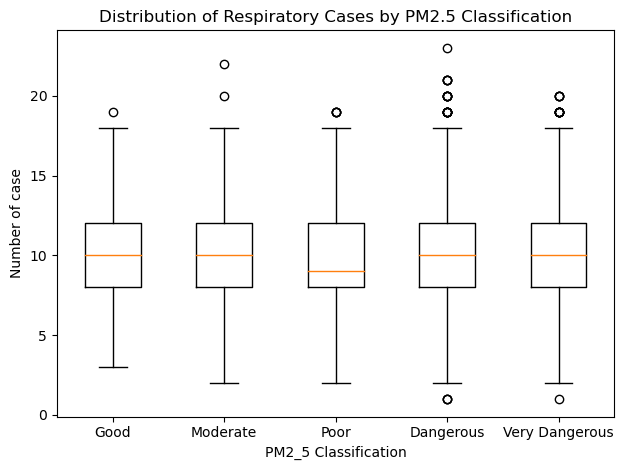

In [ ]:
# Trực quan hoá
label_list = ["Good", "Moderate", "Poor", "Dangerous", "Very Dangerous"]
plt.boxplot([good, moderate, poor, dangerous, very_dangerous], labels = label_list)
plt.ylabel("Number of case")
plt.xlabel("PM2_5 Classification")
plt.title("Distribution of Respiratory Cases by PM2.5 Classification")
plt.tight_layout();

<div>
    <b>Nhận xét</b>
    <p>Nhìn chung, số ca bệnh không có sự thay đổi quá lớn khi mức độ ô nhiễm PM2.5 tăng lên, tuy nhiên vẫn xuất hiện xu hướng gia tăng nhẹ, thể hiện qua các đặc điểm sau:</p>
    <ul>
        <li>
            <b>Khoảng phân bố dữ liệu:</b>
            <ul>
                <li>Ở mức độ <i>"Good"</i>, khoảng phân bố khá hẹp, cho thấy số ca bệnh có xu hướng ổn định hơn so với các mức độ khác.</li>
                <li>Khi mức độ ô nhiễm tăng lên, khoảng phân bố trở nên rộng hơn, phản ánh rằng sự gia tăng ô nhiễm PM2.5 có ảnh hưởng nhất định đến sự biến động của số ca bệnh, dù không quá mạnh.</li>
            </ul>
        </li>
        <li>
            <b>Giá trị ngoại lai:</b>
            <ul>
                <li>Ở các mức <i>"Dangerous"</i> và <i>"Very Dangerous"</i>, sự xuất hiện nhiều giá trị ngoại lai ở mức cao cho thấy số ca bệnh có thể tăng đột biến khi nồng độ bụi mịn đạt mức nguy hiểm.</li>
                <li>Điều này gợi ý rằng ô nhiễm không khí không chỉ làm tăng nguy cơ mắc bệnh mà còn dẫn đến một số trường hợp bùng phát vượt mức thông thường.</li>
            </ul>
        </li>
    </ul>
    <p>Những đặc điểm này nhấn mạnh sự cần thiết của việc kiểm soát chất lượng không khí, đặc biệt tại các khu vực có mức độ ô nhiễm cao, để hạn chế tác động tiềm tàng lên sức khỏe cộng đồng.</p>
</div>


**Chỉ số PM10**

In [89]:
# Lọc số ca bệnh theo nhóm PM10
good = pm_info[pm_info['PM10_Classify'] == "Good"]['RespiratoryCases']
moderate = pm_info[pm_info['PM10_Classify'] == "Moderate"]['RespiratoryCases']
poor = pm_info[pm_info['PM10_Classify'] == "Poor"]['RespiratoryCases']
dangerous = pm_info[pm_info['PM10_Classify'] == "Dangerous"]['RespiratoryCases']
very_dangerous = pm_info[pm_info['PM10_Classify'] == "Very Dangerous"]['RespiratoryCases']

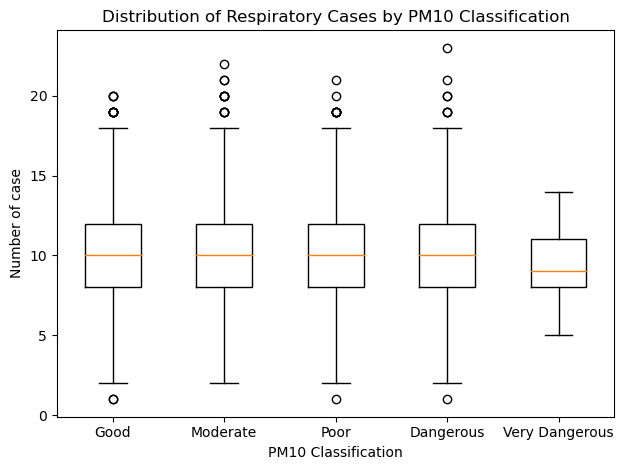

In [ ]:
# Trực quan hoá
label_list = ["Good", "Moderate", "Poor", "Dangerous", "Very Dangerous"]
plt.boxplot([good, moderate, poor, dangerous, very_dangerous], labels = label_list)
plt.ylabel("Number of case")
plt.xlabel("PM10 Classification")
plt.title("Distribution of Respiratory Cases by PM10 Classification")
plt.tight_layout();

<div>
    <b>Nhận xét</b>
    <ul>
        <li><p>Nhìn chung, PM10 dường như không có tác động đáng kể đến số ca bệnh hô hấp, khi các mức phân bố từ "Good" đến "Dangerous" gần như tương đồng và ổn định. Đặc biệt, ở mức "Very Dangerous", số ca bệnh thậm chí còn có xu hướng giảm, cho thấy rằng loại bụi có đường kính lớn này có thể phần lớn bị hệ thống lọc tự nhiên của cơ thể (như lông mũi và lớp niêm mạc) ngăn chặn trước khi xâm nhập sâu vào hệ hô hấp.</p></li>
        <li><p>Điều này gợi ý rằng PM10, mặc dù là một yếu tố ô nhiễm, có khả năng gây ra tác động thấp hơn so với các loại bụi mịn nhỏ hơn (như PM2.5) trong việc gây nên bệnh lý hô hấp. Tuy nhiên, cần thêm nghiên cứu để đánh giá chi tiết hơn về mức độ ảnh hưởng của PM10 trong các điều kiện khác nhau.</p></li>
     </ul>   
</div>

<h5>3. Kết luận</h5>

<p><strong>Thông qua phân tích sự ảnh hưởng của PM2.5 và PM10, có thể rút ra kết luận sau:</strong></p>
    <ul>
        <li>
            <strong>PM2.5 có ảnh hưởng nghiêm trọng đến sức khỏe con người, đặc biệt là hệ hô hấp,</strong> do nguồn gốc chủ yếu từ việc đốt cháy nhiên liệu và giao thông. PM2.5 dễ dàng xâm nhập vào phổi và các cơ quan nội tạng, gây ra các vấn đề như viêm phổi, hen suyễn, và các bệnh tim mạch. Do đó, việc triển khai các chính sách hạn chế nồng độ PM2.5 trong không khí là vô cùng quan trọng để bảo vệ sức khỏe cộng đồng.
        </li>
        <li>
            <strong>Mặc dù PM10 ít nguy hiểm hơn PM2.5,</strong> nhưng việc tích tụ lâu dài trong không khí cũng có thể gây ra tác động xấu đối với sức khỏe, đặc biệt là các vấn đề liên quan đến hệ thống lọc của cơ thể. Vì vậy, cũng cần triển khai các biện pháp phòng ngừa để hạn chế sự xuất hiện của bụi này.
        </li>
    </ul>
    <p>Tóm lại, mặc dù có nhiều yếu tố ảnh hưởng đến số ca bệnh hô hấp, nhưng một môi trường không có bụi, trong lành và sạch sẽ sẽ góp phần đáng kể vào việc bảo vệ và nâng cao sức khỏe cộng đồng. Việc giảm thiểu mức độ ô nhiễm không khí, đặc biệt là PM2.5 và PM10, sẽ giúp giảm thiểu các bệnh lý liên quan đến hô hấp và cải thiện chất lượng sống của người dân.</p>
</body>